In [1]:
from utils import path_setup
path_setup()
import pandas as pd
import os
from src.paths import PROCESSED_DATA
import numpy as np

import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
#from src.modeling.nn_model import build_model, early_stop
#from src.modeling.grid_search import grid_search


In [2]:
filepath=os.path.join(PROCESSED_DATA, "prepaired_data.csv")
df = pd.read_csv(filepath, index_col=0)
df.describe()

,Layer,Amp,FreQ,e,h,Optimal
count,66.000000,66.000000,66.000000,49.000000,49.000000,66.000000
mean,6.272727,4.937879,1.746970,11.073469,1.659184,0.439394
std,1.957592,0.913281,0.244458,2.185442,0.565287,0.500117
min,4.000000,2.500000,1.000000,5.400000,0.400000,0.000000
25%,5.000000,4.500000,1.600000,10.400000,1.300000,0.000000
50%,6.000000,5.000000,1.800000,11.800000,1.600000,0.000000
75%,7.750000,5.500000,1.800000,12.800000,2.000000,1.000000
max,12.000000,6.500000,2.300000,14.100000,3.600000,1.000000


In [3]:
df.loc[df.Optimal==0].count(), df.loc[df.Optimal==1].count()

(Layer      37
 Amp        37
 FreQ       37
 e          29
 h          29
 Optimal    37
 dtype: int64,
 Layer      29
 Amp        29
 FreQ       29
 e          20
 h          20
 Optimal    29
 dtype: int64)

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Подготовка
# Названия признаков
y=df["Optimal"].values
X=df[['Amp','FreQ','Layer']]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=13)
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ["Amp","FreQ","Layer"]),      # Стандартизируем Amp и FreQ
       #('pass', "passthrough",["Layer"])             # Layer не трогаем
    ]
)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def build_model(input_shape, dropout=0.3, neurons=8,learning_rate=0.001):
    tf.random.set_seed(1)
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(input_shape,) ),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    #print(model.summary())
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
from scikeras.wrappers import KerasClassifier
early_stop= EarlyStopping(
    monitor='val_loss',  # следим за ошибкой на валидации
    patience=25,         # ждём 5 эпох без улучшения
    restore_best_weights=True  # возвращаемся к лучшим весам
)
clf = KerasClassifier(
    model=build_model,
    input_shape=3,  # 3 признака
    epochs=200,
    callbacks=[early_stop],
    validation_split=0.2,
    verbose=0,
    random_state=13
)

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', clf)
])

#Подбор гиперпараметров
param_grid = {
    'clf__batch_size': [2,4,8,16],
    'clf__model__neurons': [4,8,16],
    'clf__model__dropout':[0.1, 0.3, 0.5],
    'clf__model__learning_rate': [0.1, 0.001, 0.0005]
}


grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3),
    scoring='accuracy',
    n_jobs=-1
)


grid.fit(X_trainval, y_trainval)



/Users/iplotnikow/WorkSpace/github.com/iaPlotnikovv/DS_Diploma/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/iplotnikow/WorkSpace/github.com/iaPlotnikovv/DS_Diploma/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/iplotnikow/WorkSpace/github.com/iaPlotnikovv/DS_Diploma/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Seq

,estimator,Pipeline(step... verbose=0))])
,param_grid,"{'clf__batch_size': [2, 4, ...], 'clf__model__dropout': [0.1, 0.3, ...], 'clf__model__learning_rate': [0.1, 0.001, ...], 'clf__model__neurons': [4, 8, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('scale', ...)]"


In [ ]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Best CV accuracy:", grid.best_score_)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Best Params:", grid.best_params_)

Best CV accuracy: 0.8474945533769063
Test accuracy: 0.8571428571428571
Best Params: {'clf__batch_size': 8, 'clf__model__dropout': 0.1, 'clf__model__learning_rate': 0.001, 'clf__model__neurons': 8}


2025-07-01 23:13:09.344058: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-01 23:13:09.344553: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.83      0.83      0.83         6

    accuracy                           0.86        14
   macro avg       0.85      0.85      0.85        14
weighted avg       0.86      0.86      0.86        14



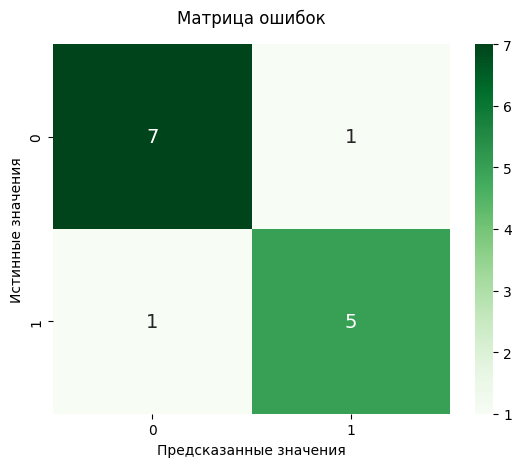

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

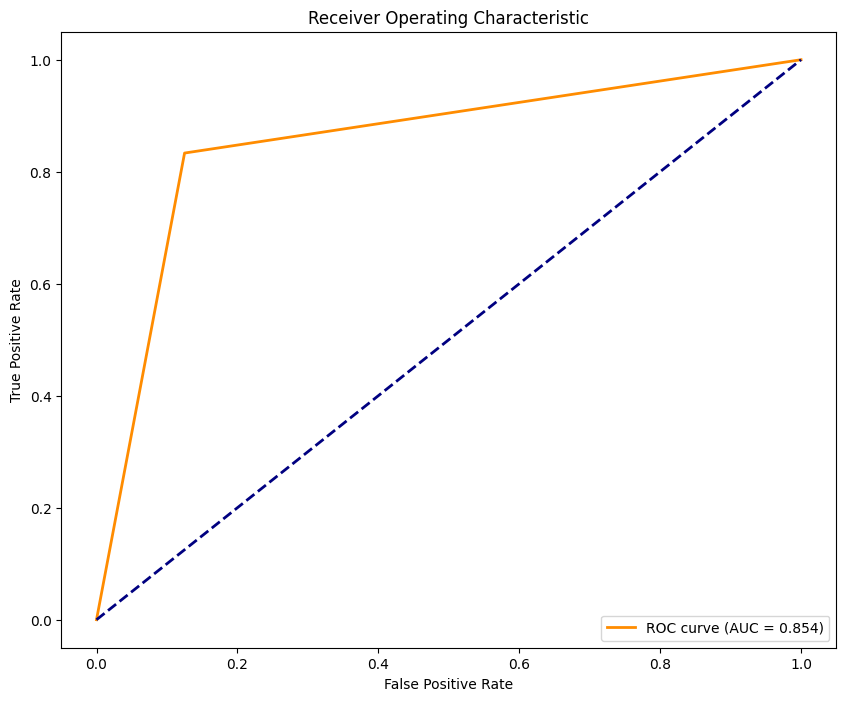

ROC AUC score: 0.854


In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Рассчитываем точки ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Вычисляем площадь под кривой
roc_auc = auc(fpr, tpr)

# Визуализируем результат
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0\.0, 1.0])
#plt.ylim([0\.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Можно также напрямую вычислить AUC
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred):.3f}")



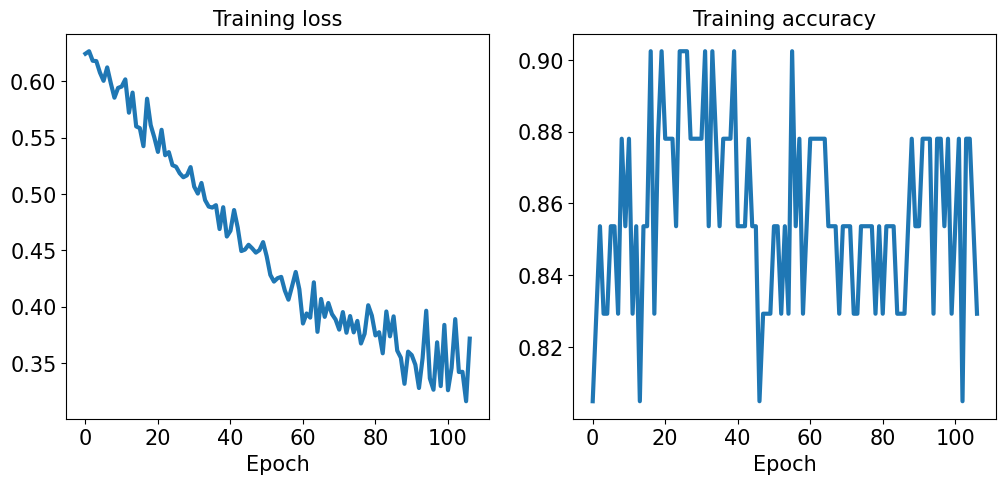

In [12]:
import matplotlib.pyplot as plt
hist=history = grid.best_estimator_.named_steps['clf'].history_
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_trainval, y_trainval)
print("RandomForest Test accuracy:", accuracy_score(y_test, pipeline_rf.predict(X_test)))

RandomForest Test accuracy: 0.7142857142857143
